# Panel estimation of wildifire probability 

In [27]:
from tsraster.prep import combine_extracted_features, combine_target_rasters, wide_to_long_target_features,unmask_df,panel_lag_1
from tsraster.calculate import checkRelevance2, calculateFeatures

from numpy import NaN,isnan
from pathlib import Path 
import os
import pandas as pd

import tsraster.prep  as tr
import tsraster.model  as md

import rasterio
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix, cohen_kappa_score
from sklearn.ensemble import GradientBoostingClassifier

### Features Extraction at Scale

In [6]:
fc_parameters = {
	    "mean": None,
	    "maximum": None,
	    "median":None}

p = Path('../Data/Examples/Panel_Example/Climate/')
folders = [str(x) for x in p.glob('*/*') if x.is_dir() and '_features' not in str(x) and 'Fire' not in str(x) ]
folders

['..\\Data\\Examples\\Panel_Example\\Climate\\2006_2010\\cwd',
 '..\\Data\\Examples\\Panel_Example\\Climate\\2006_2010\\ppt',
 '..\\Data\\Examples\\Panel_Example\\Climate\\2011_2015\\cwd',
 '..\\Data\\Examples\\Panel_Example\\Climate\\2011_2015\\ppt']

In [12]:
for folder in folders:
    if not os.listdir(folder):
        print("Directory is empty")
    else:    
        print("Directory is not empty")
        print(folder)
        ts_features = calculateFeatures(folder,
                                        parameters=fc_parameters,
                                        reset_df=True,
                                        tiff_output=False,
                                        raster_mask =  r"../Data/Examples/buffer/StatePoly_buf.tif",
                                        workers = 1)
        print(ts_features.describe())
        del ts_features

Directory is not empty
..\Data\Examples\Panel_Example\Climate\2006_2010\cwd
df: ..\Data\Examples\Panel_Example\Climate\2006_2010\cwd\my_df.csv


Feature Extraction: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:50<00:00, 10.46s/it]


features:..\Data\Examples\Panel_Example\Climate\2006_2010\cwd_features\extracted_features.csv
       cwd__maximum     cwd__mean   cwd__median
count  1.137669e+06  1.137669e+06  1.137669e+06
mean  -6.321948e+03 -6.361746e+03 -6.369084e+03
std    4.893647e+03  4.840688e+03  4.830975e+03
min   -9.999000e+03 -9.999000e+03 -9.999000e+03
25%   -9.999000e+03 -9.999000e+03 -9.999000e+03
50%   -9.999000e+03 -9.999000e+03 -9.999000e+03
75%    1.838448e+02  6.138217e+01  1.257800e+01
max    2.327495e+02  1.318143e+02  1.334538e+02
Directory is not empty
..\Data\Examples\Panel_Example\Climate\2006_2010\ppt
df: ..\Data\Examples\Panel_Example\Climate\2006_2010\ppt\my_df.csv


Feature Extraction: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:53<00:00, 10.89s/it]


features:..\Data\Examples\Panel_Example\Climate\2006_2010\ppt_features\extracted_features.csv
       ppt__maximum     ppt__mean   ppt__median
count  1.137669e+06  1.137669e+06  1.137669e+06
mean  -6.318338e+03 -6.375807e+03 -6.383758e+03
std    4.899379e+03  4.822003e+03  4.811385e+03
min   -9.999000e+03 -9.999000e+03 -9.999000e+03
25%   -9.999000e+03 -9.999000e+03 -9.999000e+03
50%   -9.999000e+03 -9.999000e+03 -9.999000e+03
75%    7.860650e+01  1.487717e+01  4.968500e+00
max    1.191274e+03  3.167586e+02  2.474300e+02
Directory is not empty
..\Data\Examples\Panel_Example\Climate\2011_2015\cwd
df: ..\Data\Examples\Panel_Example\Climate\2011_2015\cwd\my_df.csv


Feature Extraction: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:49<00:00, 10.28s/it]


features:..\Data\Examples\Panel_Example\Climate\2011_2015\cwd_features\extracted_features.csv
       cwd__maximum     cwd__mean   cwd__median
count  1.137669e+06  1.137669e+06  1.137669e+06
mean  -6.322409e+03 -6.360048e+03 -6.362518e+03
std    4.893033e+03  4.842955e+03  4.839713e+03
min   -9.999000e+03 -9.999000e+03 -9.999000e+03
25%   -9.999000e+03 -9.999000e+03 -9.999000e+03
50%   -9.999000e+03 -9.999000e+03 -9.999000e+03
75%    1.842680e+02  6.424258e+01  4.230175e+01
max    2.329300e+02  1.402930e+02  1.575240e+02
Directory is not empty
..\Data\Examples\Panel_Example\Climate\2011_2015\ppt
df: ..\Data\Examples\Panel_Example\Climate\2011_2015\ppt\my_df.csv


Feature Extraction: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:51<00:00, 10.52s/it]


features:..\Data\Examples\Panel_Example\Climate\2011_2015\ppt_features\extracted_features.csv
       ppt__maximum     ppt__mean   ppt__median
count  1.137669e+06  1.137669e+06  1.137669e+06
mean  -6.317016e+03 -6.376843e+03 -6.383711e+03
std    4.901381e+03  4.820616e+03  4.811441e+03
min   -9.999000e+03 -9.999000e+03 -9.999000e+03
25%   -9.999000e+03 -9.999000e+03 -9.999000e+03
50%   -9.999000e+03 -9.999000e+03 -9.999000e+03
75%    7.883900e+01  1.455392e+01  6.439800e+00
max    1.559048e+03  2.847197e+02  2.021816e+02


### Organize data

* Climate_feature_subset_train
    * 2001_2005
        * aet_features
            * extracted_features.csv
            * ...
        * ppt_features
            * extracted_features.csv
            * ...        
    * 2006_2010
        * aet_features
            * extracted_features.csv
            * ...
        * ppt_features
            * extracted_features.csv
            * ...  
    * 2011_2015

### append all features to one dataframe

In [2]:

path = r'../Data/Examples/Panel_Example/Climate/'

concatenated_attribute_df = combine_extracted_features(path,write_out=False)


Combining folder year names ['20062010', '20062010', '20112015', '20112015']


C:\Users\mmann\AppData\Local\Continuum\anaconda2\envs\ts-rasterv2\lib\site-packages\numpy\lib\arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
concatenated_attribute_df.head()

,cwd__maximum-20062010,cwd__mean-20062010,cwd__median-20062010,ppt__maximum-20062010,ppt__mean-20062010,ppt__median-20062010,cwd__maximum-20112015,cwd__mean-20112015,cwd__median-20112015,ppt__maximum-20112015,ppt__mean-20112015,ppt__median-20112015
pixel_id,,,,,,,,,,,,
0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
1,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
2,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
3,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
4,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0


collect multitple years of Y (target) data

In [4]:
path = r"../Data/Examples/Panel_Example/Fire/"
target_file_prefix = 'fire_'

concatenated_target_df = combine_target_rasters(path,
                                                target_file_prefix,
                                                write_out=False)

In [5]:
concatenated_target_df.head()

,Y-20062010,Y-20112015
pixel_id,,
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


mask both the attribute data and targets 

In [7]:
raster_mask =u"../Data/Examples/buffer/StatePoly_buf.tif"
original_df = [concatenated_attribute_df, concatenated_target_df]

mask_attributes_df, mask_target_df = tr.mask_df(raster_mask, 
                                                original_df,  
                                                missing_value=-9999,
                                                reset_index = False)

In [8]:
mask_attributes_df.head()

,cwd__maximum-20062010,cwd__mean-20062010,cwd__median-20062010,ppt__maximum-20062010,ppt__mean-20062010,ppt__median-20062010,cwd__maximum-20112015,cwd__mean-20112015,cwd__median-20112015,ppt__maximum-20112015,ppt__mean-20112015,ppt__median-20112015
pixel_id,,,,,,,,,,,,
134588,95.193573,10.808438,0.0,535.173157,154.437119,116.529739,84.842857,16.329674,0.0000,565.594971,150.687866,108.165001
134589,114.003502,20.163677,0.0,552.677979,161.583511,122.655746,95.689499,25.205521,0.0000,589.078491,156.253983,111.509003
134590,157.690506,24.496553,0.0,564.724487,166.094742,126.713501,132.104996,26.933245,0.0000,578.199524,152.994583,109.597748
134591,160.140396,25.144434,0.0,580.050781,172.390976,132.294403,135.035995,26.979912,0.0000,588.890015,155.064163,109.506195
134592,162.972397,26.338125,0.0,600.773621,179.457764,138.405792,138.880005,27.230467,0.2344,631.367188,165.473877,115.161003


In [9]:
mask_target_df.head()

,Y-20062010,Y-20112015
pixel_id,,
134588,0,0
134589,0,0
134590,0,0
134591,0,0
134592,0,0


switch panel data from wide to long format

In [10]:
target_ln, features_ln = wide_to_long_target_features(target = mask_target_df,
                                                      features = mask_attributes_df,
                                                      sep='-')

converted to long, indexes match


Show size and repeated obs by pixel cell

In [14]:
features_ln.sort_index().head(10)

ppt__median  cwd__median   ppt__mean  ppt__maximum  \
pixel_id time                                                           
134588   20062010   116.529739       0.0000  154.437119    535.173157   
         20112015   108.165001       0.0000  150.687866    565.594971   
134589   20062010   122.655746       0.0000  161.583511    552.677979   
         20112015   111.509003       0.0000  156.253983    589.078491   
134590   20062010   126.713501       0.0000  166.094742    564.724487   
         20112015   109.597748       0.0000  152.994583    578.199524   
134591   20062010   132.294403       0.0000  172.390976    580.050781   
         20112015   109.506195       0.0000  155.064163    588.890015   
134592   20062010   138.405792       0.0000  179.457764    600.773621   
         20112015   115.161003       0.2344  165.473877    631.367188   

                   cwd__mean  cwd__maximum  
pixel_id time                               
134588   20062010  10.808438     95.193573  
         20112015  16.329674     84.842857  
134589   20062010  20.163677    114.003502  
         20112015  25.205521     95.689499  
134590   20062010  24.496553    157.690506  
         20112015  26.933245    132.104996  
134591   20062010  25.144434    160.140396  
         20112015  26.979912    135.035995  
134592   20062010  26.338125    162.972397  
         20112015  27.230467    138.880005

In [15]:
target_ln.sort_index().head(10)

Y
pixel_id time       
134588   20062010  0
         20112015  0
134589   20062010  0
         20112015  0
134590   20062010  0
         20112015  0
134591   20062010  0
         20112015  0
134592   20062010  0
         20112015  0

### add temporal lagged variables 

In [18]:

lag_vars = ['ppt__median',
 'cwd__mean',
 'cwd__mean']    


features_ln = panel_lag_1(features_ln, 
                          col_names=lag_vars, 
                          group_by_index ='pixel_id')


adding a temporal lag implies that one time period will be lost

In [19]:
features_ln.head()

,,ppt__median,cwd__median,ppt__mean,ppt__maximum,cwd__mean,cwd__maximum,ppt__median_1,cwd__mean_1,cwd__mean_1
pixel_id,time,,,,,,,,,
134588,20112015,108.165001,0.0000,150.687866,565.594971,16.329674,84.842857,116.529739,10.808438,10.808438
134589,20112015,111.509003,0.0000,156.253983,589.078491,25.205521,95.689499,122.655746,20.163677,20.163677
134590,20112015,109.597748,0.0000,152.994583,578.199524,26.933245,132.104996,126.713501,24.496553,24.496553
134591,20112015,109.506195,0.0000,155.064163,588.890015,26.979912,135.035995,132.294403,25.144434,25.144434
134592,20112015,115.161003,0.2344,165.473877,631.367188,27.230467,138.880005,138.405792,26.338125,26.338125


join and test train split yX data, define groups of independent objects by pixel id

although not case here, you will typically have multiple observations from a single pixel, therefore it is important to group by pixel_id index, this ensures that each pixel is only included in either the training or testing data

In [21]:
obj = [target_ln,features_ln]

X_train, X_test, y_train, y_test = md.get_data(obj,
                                            stratify=True,
                                            test_size=0.9,
                                            scale=False,
                                            groups =  features_ln.index.get_level_values('pixel_id') )

input should be csv or pandas dataframe with yX, or [y,X]
reading in list concat on common index
need to figure out groups with stratification by y


### Filter variables and train model

Find relevant variables and combine Y and X data

In [28]:
relevant_vars, X_train_relevant = checkRelevance2(x=X_train,
                                                  y=y_train,
                                                  fdr_level=0.01) 
print(relevant_vars)

#X_test_relevant = X_test[X_train_relevant.columns]

ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long long'

train a gradient booster classifier 

In [19]:
clf = GradientBoostingClassifier(n_estimators=400, learning_rate=0.1,
                                 max_depth=2, random_state=0).fit(X_train[X_train_relevant.columns], y_train)

 

In [20]:
predict_test = clf.predict(X=X_test[X_train_relevant.columns])

test_acc = accuracy_score(y_test, predict_test)
kappa = cohen_kappa_score(y_test, predict_test)
confusion = confusion_matrix(y_test, predict_test)

print('Testing accuracy:',test_acc)
print('Testing Kappa: ',kappa)
print('Testing Conf: ')
print(confusion)

Testing accuracy: 0.9849629376480432
Testing Kappa:  0.05931517869865699
Testing Conf: 
[[167080     18]
 [  2534     82]]


Look at feature importance

In [23]:
feature_importances = pd.DataFrame(clf.feature_importances_,
                                   index = X_test_relevant.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
 
feature_importances.head(10)

,importance
ppt__mean_change,0.061058
"ppt__agg_linear_trend__f_agg_""max""__chunk_len_6__attr_""slope""_1",0.060758
ppt__maximum,0.059118
pet__quantile__q_0.05,0.052816
"ppt__agg_linear_trend__f_agg_""max""__chunk_len_6__attr_""slope""",0.046017
cwd__mean_change,0.039922
ppt__last_location_of_minimum,0.032166
ppt__maximum_1,0.031376
"tmx__agg_linear_trend__f_agg_""max""__chunk_len_6__attr_""slope""_1",0.030075
"ppt__agg_linear_trend__f_agg_""min""__chunk_len_6__attr_""slope""",0.029910


predict to all observations in panel
get predicted class and probability of class

In [24]:
concatenated_df_predict = md.model_predict(model = clf,
                                        new_X = features_ln[X_train_relevant.columns])

concatenated_df_prob =  md.model_predict_prob(model = clf,
                                        new_X = features_ln[X_train_relevant.columns])

isolate one 5 year period for mapping 


In [25]:

concatenated_df_prob_1996 = concatenated_df_prob.query('time == "19962000" ')
concatenated_df_prob_1996.index = concatenated_df_prob_1996.index.get_level_values(0) 

concatenated_df_prob_1996.describe()

,0,1
count,424284.000000,424284.000000
mean,0.980478,0.019522
std,0.039986,0.039986
min,0.001744,0.000177
25%,0.978398,0.002558
50%,0.992058,0.007942
75%,0.997442,0.021602
max,0.999823,0.998256


unmask values 

In [26]:

unmask_concatenated_df_prob_1996 = tr.unmask_df(concatenated_attribute_df, 
                                                concatenated_df_prob_1996)

 
unmask_concatenated_df_prob_1996 = unmask_df(original_df = concatenated_attribute_df,
                                             mask_df_output = concatenated_df_prob_1996) 

# keep only class prob of fire event 
unmask_concatenated_df_prob_1996 = unmask_concatenated_df_prob_1996.iloc[:,1]
unmask_concatenated_df_prob_1996[unmask_concatenated_df_prob_1996== -9999 ]= NaN 

unmask_concatenated_df_prob_1996.describe()

C:\Users\mmann\AppData\Local\Continuum\anaconda2\envs\ts-rasterv2\lib\site-packages\pandas\core\frame.py:4290: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[col] = expressions.where(mask, this, that)


count    424284.000000
mean          0.019522
std           0.039986
min           0.000177
25%           0.002558
50%           0.007942
75%           0.021602
max           0.998256
Name: 1, dtype: float64

### rasterize and plot prediction

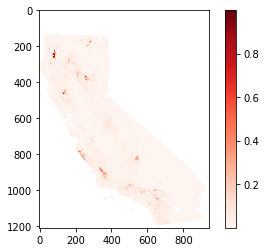

In [27]:
raster_ex = "F:/5year/aet/aet-201201.tif"
ex_row, ex_cols =  rasterio.open(raster_ex).shape

f2Array = unmask_concatenated_df_prob_1996.values.reshape(ex_row, ex_cols)
 # Plot the grid

plt.imshow(f2Array)
plt.set_cmap("Reds")
plt.colorbar( )
plt.show()

compare to actual

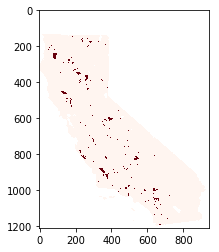

In [32]:

path = r"G:\Fire_target_train\fire_1996_2000.tif"
image_name = tr.image_names(path)
rasters = tr.image_to_array(path)[:,:,0]
rasters[isnan(f2Array)] = NaN

plt.imshow(rasters)
plt.set_cmap("Reds")
plt.show()
